In [ ]:
!pip install transformers
!pip install nltk
!pip install datasets
!pip install sentencepiece
!pip install sacrebleu
!pip install rouge_score
!pip install py7zr
!pip install accelerate -U

# CNN/Daily Mail Dataset

In [2]:
from datasets import load_dataset
import nltk
from nltk.tokenize import sent_tokenize
nltk.download("punkt")

from transformers import pipeline,set_seed

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
dataset = load_dataset("cnn_dailymail", version="3.0.0")
print(f"Features of dataset : {dataset['train'].column_names}")

Features of dataset : ['article', 'highlights', 'id']


In [ ]:
sample = dataset["train"][1]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample["article"])}):""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article (excerpt of 500 characters, total length: 4051):
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary (length: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


In [ ]:
sample_text = dataset["train"][1]["article"][:2000]
# We'll collect the generated summaries of each model in a dictionary
summaries = {}

In [ ]:
#baseline summary just extracting first 3 sentences as summary
def three_sentence_summary(text):
  return "\n".join(sent_tokenize(text)[:3])
summaries["baseline"] = three_sentence_summary(sample_text)

In [ ]:
set_seed(42)

pipe = pipeline("text-generation",model="gpt2")

gpt_query = sample_text + "\nTL;DR:\n"

pipe_out = pipe(gpt_query,max_length=512,clean_up_tokenization_spaces=True)

summaries["gpt2"] = "\n".join(sent_tokenize(pipe_out[0]["generated_text"][len(gpt_query) :]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
#Summarization with T5-Model....
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [ ]:
#Summarization using BARD from facebook.....
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [ ]:
#Summarization with PEGASUS
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

In [ ]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")
for model_name in summaries:
  print(model_name.upper())
  print(summaries[model_name])
  print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

GPT2

To be clear, prisoners who feel like they can't go to the other side of the court do not actually face the law, he says.
Instead, they are detained and charged with a crime.
Many prisoners in these cases can't even be

# Measuring quality of generated text
1. BLEU : BiLingual Evaluation Understudy

  - Precision based metric where we calaculated by comparing reference text and generated text.

In [3]:
#importing packages

from datasets import load_metric

import pandas as pd
import numpy as np

In [ ]:
bleu_metric = load_metric("sacrebleu")

In [ ]:
bleu_metric.add(prediction="the the the the the the", reference=["the cat is on the mat"])

results = bleu_metric.compute(smooth_method="floor", smooth_value=0)

results["precisions"] = [np.round(p, 2) for p in results["precisions"]]

pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [ ]:
bleu_metric.add(prediction="the cat is on mat", reference=["the cat is on the mat"])

results = bleu_metric.compute(smooth_method="floor", smooth_value=0)

results["precisions"] = [np.round(p, 2) for p in results["precisions"]]

pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


# Measuring Quality of text

1. Recall Oriented Understudy for Gisting Evaluation (ROUGE)
 - Original idea is to come up with metric as like BLUE but here it is based on recall i.e. calculated matching n-grams between generated and reference text divide by length of reference text
 - But this given some problems so they combined both recall and precision to come up with F-score which is now called as ROGUE score
 - 2 types of ROUGE score :
 - - ROUGE-L : Calculate score per sentence and then averages for whole summary
 - - ROUGE-Lsum : Calculated score over whole summary text both refrence and generated text

In [ ]:
#rogue_metric
rouge_metric = load_metric("rouge")
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

In [ ]:
reference =  dataset['train'][1]['highlights']
records   = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
  rouge_metric.add(prediction=summaries[model_name], reference=reference)
  score = rouge_metric.compute()
  rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
  records.append(rouge_dict)

pd.DataFrame.from_records(records, index=summaries.keys())

# Evaluation of CNN/Mail dataset on Baseline summaries and PEGASUS model

In [ ]:
#fucntion to evaluated model on the baseline summaries

def evaluate_on_basline_summaries(dataset,metric,column_text="article",column_sum = "highlights"):

  summaries = [three_sentence_summary(text) for text in dataset[column_text]]
  metric.add_batch(predictions = summaries, references = dataset[column_sum])
  score = metric.compute()

  return score


In [ ]:
test_dataset = dataset['test'].shuffle(seed=42).select(range(1000))


In [ ]:
#evalation of baseline summaries
eval_base = evaluate_on_basline_summaries(test_dataset,rouge_metric)
rouge_dict = dict((rn, eval_base[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.389206,0.171495,0.245012,0.354296


In [5]:
from tqdm import tqdm
import torch

In [6]:
#evalating dataset on PEGASUS model.....

def chunk(list_of_elements,batch_size):
  """Yield successive batch-sized chunks from list_of_elements."""
  for i in range(0, len(list_of_elements), batch_size):
    yield list_of_elements[i : i + batch_size]

def evaluate_pegasus(model,tokenizer,dataset,metric,device,batch_size=8, column_text = "article", column_sum = "highlights",):

  article_batch = list(chunk(dataset[column_text],batch_size))
  sum_batch     = list(chunk(dataset[column_sum],batch_size))

  for ar_batch,tar_batch in tqdm(zip(article_batch,sum_batch),total=len(article_batch)):

    inputs = tokenizer(ar_batch,max_length = 1024,truncation =True,return_tensors = "pt",padding = "max_length")

    summaries = model.generate(input_ids = inputs['input_ids'].to(device),
                               attention_mask=inputs['attention_mask'].to(device),
                               length_penalty=0.8,max_length = 128,num_beams = 8)

    decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,clean_up_tokenization_spaces=True) for s in summaries]

    decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]

    metric.add_batch(predictions=decoded_summaries, references=tar_batch)

  score = metric.compute()

  return score

In [7]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
score = evaluate_pegasus(model,tokenizer,test_dataset,rouge_metric,device, batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)

pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 125/125 [25:08<00:00, 12.07s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.434514,0.215995,0.312071,0.374301


# Training a summarization model (Fine Tuning PEGASUS)

In [8]:
import matplotlib.pyplot as plt

In [9]:
#We will try to fine-tune PEGASUS model on the SAMSum Dataset
#SAMSum dataset is interaction between customer and user over a chat along with their summaries so
#we try to fine-tune model on this dataset and find if it can improve model performance...

dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

In [ ]:
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [ ]:
#Let us just try to evaluate on base model before fine-tuning...
sam_score = evaluate_pegasus(model,tokenizer,dataset_samsum["test"],rouge_metric,device, batch_size=8,column_text = "dialogue",column_sum = "summary")

In [ ]:
rouge_dict = dict((rn, sam_score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296366,0.087708,0.229321,0.229187


In [ ]:
#Finding the lengths of text in dialogue and summary to understand their distributions....
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


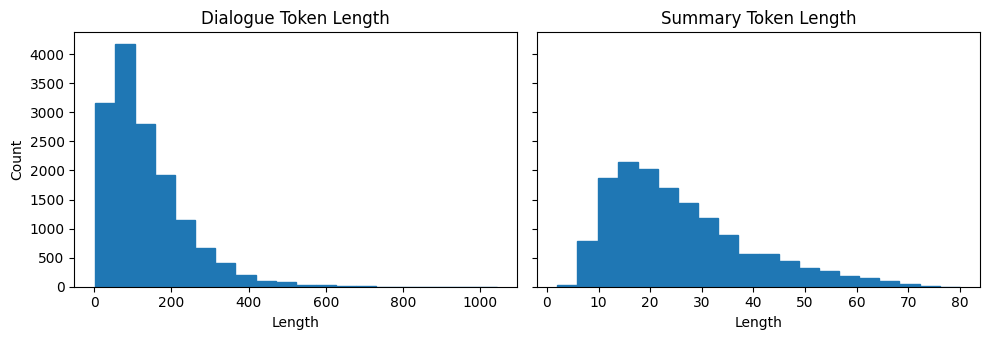

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [10]:
#converting text to features.....

def convert_text2features(batch):

  inputs = tokenizer(batch['dialogue'],max_length = 1024,truncation = True)

  #we have this method to toknize text as per the ouptput model as sometime decoder uses special tokens to identify them...
  with tokenizer.as_target_tokenizer():
    target_encodings = tokenizer(batch["summary"], max_length=128,truncation=True)

  return {"input_ids": inputs["input_ids"],"attention_mask": inputs["attention_mask"],"labels": target_encodings["input_ids"]}


In [ ]:
dataset_samsum_pt = dataset_samsum.map(convert_text2features,batched=True)

columns = ["input_ids", "labels", "attention_mask"]

dataset_samsum_pt.set_format(type="torch", columns=columns)

In [13]:
dataset_samsum_pt['train']

Dataset({
    features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 14732
})

In [14]:
#data collator is used to do 1 right shift of ouptut so that model does not see future outputs before hand
from transformers import DataCollatorForSeq2Seq
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [15]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir='pegasus-samsum',
                                  num_train_epochs=1,
                                  warmup_steps=500,
                                  per_device_train_batch_size=1,
                                  per_device_eval_batch_size=1,weight_decay=0.01,
                                  logging_steps=10,
                                  push_to_hub=False,
                                  evaluation_strategy='steps',
                                  eval_steps=500,
                                  save_steps=1e6,
                                  gradient_accumulation_steps=16)

In [16]:
trainer = Trainer(model=model,
                  args=training_args,
                  tokenizer=tokenizer,
                  data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [17]:
trainer.train()

You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,1.631500,1.488017


TrainOutput(global_step=920, training_loss=1.8223454102225927, metrics={'train_runtime': 2804.2327, 'train_samples_per_second': 5.253, 'train_steps_per_second': 0.328, 'total_flos': 5526698901602304.0, 'train_loss': 1.8223454102225927, 'epoch': 1.0})

In [18]:
tuned_samsun_score = evaluate_pegasus(trainer.model,tokenizer,dataset_samsum["test"],rouge_metric,"cuda", batch_size=2,column_text = "dialogue",column_sum = "summary")

100%|██████████| 410/410 [14:07<00:00,  2.07s/it]


In [19]:
rouge_dict = dict((rn, tuned_samsun_score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.42595,0.194461,0.339657,0.339301


In [21]:
trainer.model.save("tuned-pegasus")

AttributeError: ignored

In [24]:
trainer.save_model('tuned-pegasus')

In [25]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="tuned-pegasus")
print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry. Amanda will text Larry.


In [26]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Thom, Lewis and Leandro are going to write a book about transformers. Thom helped build a library by Hugging Face. They are going to do it together.
